In [1]:
import os
import pandas as pd
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.ma as ma
from scipy.spatial import KDTree
from datetime import datetime

In [2]:
vols = ["Erebus", "ErtaAle", "Etna",
        "Kilauea", "Masaya", "Nyamuragira",
        "Nyiragongo", "Pacaya", "Puuoo"]
lats = [-77.526742, 13.604800, 37.750523,
        19.406872, 11.984590, -1.409965,
        -1.522090, 14.382577, 19.388577]
lons = [167.162911, 40.662474, 14.993409,
        -155.283322, -86.167743, 29.204206,
        29.249658, -90.601904, -155.105781]

meta_df = pd.DataFrame(vols)
meta_df = meta_df.rename(columns = {0:'vols'})
meta_df['lats'] = lats; meta_df['lons'] = lons
meta_df

,vols,lats,lons
0,Erebus,-77.526742,167.162911
1,ErtaAle,13.604800,40.662474
2,Etna,37.750523,14.993409
3,Kilauea,19.406872,-155.283322
4,Masaya,11.984590,-86.167743
5,Nyamuragira,-1.409965,29.204206
6,Nyiragongo,-1.522090,29.249658
7,Pacaya,14.382577,-90.601904
8,Puuoo,19.388577,-155.105781


# Subsetting down from the entire satellite scene

In [3]:
for vol in os.listdir('data'):
    # Import reference dataframe (made with level-1 data)
    good_df = pd.read_csv("data/" + vol + "/good_df.csv")
    # If Erebus, skipping the missing/NA scenes
    if vol == 'Erebus':
        good_df['acquisition_datetimes'] = [file.split('_')[2] for file in good_df['nighttime_volcano_files']]
        good_df = good_df[good_df.acquisition_datetimes != '00304102013143221'] 
        good_df = good_df[good_df.acquisition_datetimes != '00308162018142109']
        good_df = good_df.reset_index()
        

    # Read all the level-2 data files
    vol_dir = "AST_08_data/" + vol + "/e4ftl01.cr.usgs.gov/"
    vol_files = os.listdir(vol_dir)
    all_tif_files = [file for file in vol_files if '.tif' in file]
    tif_files = [file for file in all_tif_files if '.tif.met' not in file]
    # Reconstruct dates from those level-2 files
    dates = [tif.split('_')[2] for tif in tif_files]
    year = [date[7:11] for date in dates]
    month = [date[3:5] for date in dates]
    day = [date[5:7] for date in dates]
    formatted_dates = []
    for i in range(len(dates)):
        formatted_dates.append(year[i] + '-' + month[i] + '-' + day[i])

    # Percent of new data that are in old data
    df_dates = list(good_df['dates'])
    indications = []
    for frmtd_date in formatted_dates:
        indications.append(frmtd_date in df_dates)
    new_in_old = sum(indications)/len(indications)

    # Percent of old data that are in new data
    indications = []
    for df_date in df_dates:
        indications.append(df_date in formatted_dates)
    old_in_new = sum(indications)/len(indications)

    # Make that all the same scenes are represented in level-1 and level-2 data
    if vol != 'Erebus': # known issue... out of 487 scenes, 2 are not available for some reason
        assert(old_in_new == new_in_old == 1.0)

    # Getting spatial reference for subsetting the level-2 data
    current_lat = meta_df[meta_df['vols'] == vol]['lats'].item()
    current_lon = meta_df[meta_df['vols'] == vol]['lons'].item()

    # Creating an empty array to store the subsetted level-2 data in
    subset_time_series = np.zeros([len(tif_files), 96, 96])

    # Base index via good_df because it is chronologically sorted
    for raw_i in range(len(good_df)):
        # Get the first date in the data
        scene_date = good_df['dates'][raw_i]
        # Locate the corresponding level-2 data file
        i = formatted_dates.index(scene_date)
        # Recreate the full path for that file: directory + file
        tif_file = vol_dir + tif_files[i]

        # Specifying that we want to transform to lat/lon from UTM
        dst_crs = 'EPSG:4326'
        # Performing the conversion, writing to placeholder filer
        with rasterio.open(tif_file) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            with rasterio.open('temp.tif', 'w', **kwargs) as dst:
                for k in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, k),
                        destination=rasterio.band(dst, k),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
        # Reading in the placeholder file
        src2 = rasterio.open('temp.tif')

        # Determine the pixel location of the focal coordinates
        x, y = src2.index(current_lon, current_lat)
        # Storing a 96x96 subset centered at the focal coordinates
        ## Accounting for the one exception that occurred, will address others if they emerge
        ### If there are not enough pixels near the edge of scene, allow remainder to be zero
        ### and store what you can
        if x < 48:
            buffer = 48 - x
            subset_time_series[raw_i][buffer:, :] = src2.read()[0, x-48+buffer:x+48, y-48:y+48]
        elif (src2.read().shape[1] - x < 48):
            buffer = 48 - (src2.read().shape[1] - x)
            subset_time_series[raw_i][:-buffer, :] = src2.read()[0, x-48:x+48-buffer, y-48:y+48]
        else:
            subset_time_series[raw_i] = src2.read()[0, x-48:x+48, y-48:y+48]
        # Delete the in-memory placeholder file so that it can be rewritten
        del(src2)
        
    np.save('AST_08_data/' + vol + '/raw_geotransf_subsets', subset_time_series)

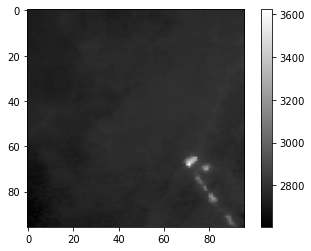

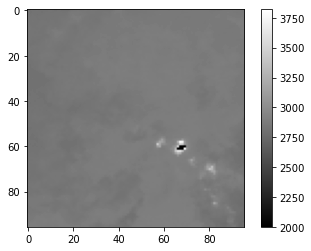

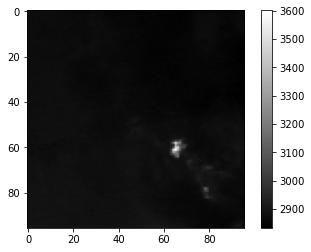

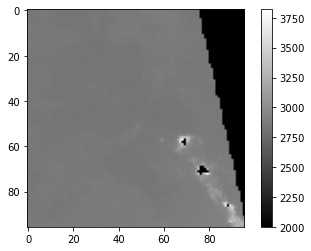

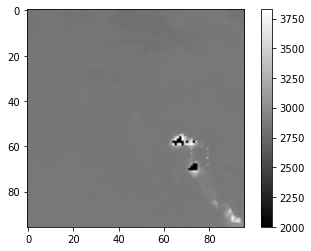

In [4]:
testing = np.load('AST_08_data/Puuoo/raw_geotransf_subsets.npy')

for i in range(15, 20):
    plt.imshow(testing[i], cmap = 'gist_gray')
    plt.colorbar()
    plt.pause(0.001)

# Filling in odd darkspots in the middle of the scene with their nearest spatial neighbor

In [5]:
for vol in os.listdir('data/'):
    print(vol)
    # Construct the filepath to the level-2 spatial subsets and import the  data
    level2_subsets = np.load('AST_08_data/' + vol + '/raw_geotransf_subsets.npy')
    
    # There are two types of missing values
    # val = 0 means that the pixel is out of the total extent of the image
    missing_vals_0 = (level2_subsets == 0)
    # val = 2000 means that the pixel is in the total extent but not observed
    # or the strange darkspot values
    missing_vals_2000 = (level2_subsets == 2000)
    # Add the boolean indicators to identify both cases
    missing_vals_all = missing_vals_0 + missing_vals_2000
    # Identify all the locations where missing values occur
    scenes_i, x, y = np.where(missing_vals_all == True)
    # Create a new array to locate missing values of interest
    #     as opposed to missing values that are simply beyond the border
    level2_subsets2 = level2_subsets.copy()
    # Also, creating a new array to store the nearest neighbor interpolated output
    neighbor_filled = level2_subsets.copy()

    # For every scene...
    for i in range(len(level2_subsets)):
        # Identify if that scene contains missing values
        missing_in_scene = np.where(scenes_i == i)[0]
        num_missing_in_scene = len(missing_in_scene)
        # If not, there is no interpolation needed
        if num_missing_in_scene == 0:
            pass
        # If so, perform nearest neighbor interpolation, if there are neighbors in
        # at least 3 directions
        #     This will interpolate darkspots in the middle and edge but not borders
        else:
            # Extract only the scene of interest
            full_scene = level2_subsets[i]
            # For all the coordinate pairs corresponding to missing values...
            for coord_i in missing_in_scene:
                # Extract the coordinates
                x_miss = x[coord_i]
                y_miss = y[coord_i]
                # Determine if there are valid values in each 4 directions
                directional_vectors = [] # boolean
                directional_vectors_t = [] # temperatures
                #     West direction, conditioned because of python indexing
                if x_miss != 0:
                    west_vector = missing_vals_all[i, :x_miss, y_miss]
                    west_vector_t = full_scene[:x_miss, y_miss]
                    directional_vectors.append(west_vector)
                    directional_vectors_t.append(west_vector_t)
                #     South direction, conditioned because of python indexing
                if y_miss != 0:
                    south_vector = missing_vals_all[i, x_miss, :y_miss]
                    south_vector_t = full_scene[x_miss, :y_miss]
                    directional_vectors.append(south_vector)
                    directional_vectors_t.append(south_vector_t)
                #     East direction
                east_vector = missing_vals_all[i, x_miss:, y_miss]
                east_vector_t = full_scene[x_miss:, y_miss]
                directional_vectors.append(east_vector)
                directional_vectors_t.append(east_vector_t)
                #     North direction
                north_vector = missing_vals_all[i, x_miss, y_miss:]
                north_vector_t = full_scene[x_miss, y_miss:]
                directional_vectors.append(north_vector)
                directional_vectors_t.append(north_vector_t)
                #     Insure that missing values do not represent the entire direction
                valid_directions = 0
                directions_for_neighbors = []
                count = 0
                for direction in directional_vectors:
                    perc_missing = sum(direction) / len(direction)
                    if perc_missing != 1:
                        valid_directions += 1
                        directions_for_neighbors.append(directional_vectors_t[count])
                    count += 1
                if valid_directions >= 3:
                    level2_subsets2[i, x_miss, y_miss] = -99
                    
        # Performing the nearest neighbor interpolation
        full_scene = level2_subsets2[i].copy()
        # Setting up a masked array to identify the pixels to interpolate for
        full_scene = ma.masked_array(full_scene, full_scene == -99)
        # Explicitly retrieving good and bad locations from the mask
        # note that these differ from (x, y) which earlier defined bad pixel locations
        X, Y = np.mgrid[0:full_scene.shape[0], 0:full_scene.shape[1]]
        xygood = np.array((X[~full_scene.mask], Y[~full_scene.mask])).T
        xybad = np.array((X[full_scene.mask], Y[full_scene.mask])).T
        # Performing the nearest neighbor gap-filling
        full_scene[full_scene.mask] = full_scene[~full_scene.mask][KDTree(xygood).query(xybad)[1]]
        neighbor_filled[i] = full_scene
        
    # Storing the neighbor-filled array while marking the still-missing values with a mask
    neighbor_filled = ma.masked_array(neighbor_filled, ((neighbor_filled == 2000) + (neighbor_filled == 0)))
    neighbor_filled.dump('AST_08_data/' + vol + '/darkspot_filled')

Erebus
ErtaAle
Etna
Kilauea
Masaya
Nyamuragira
Nyiragongo
Pacaya
Puuoo


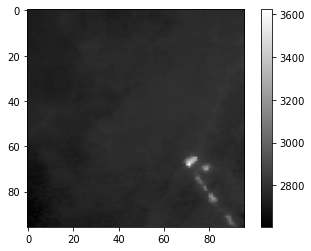

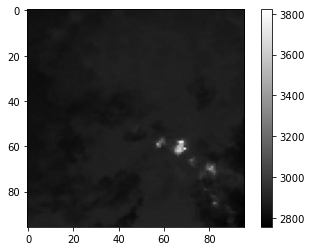

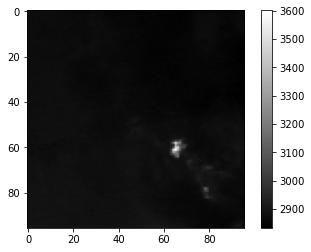

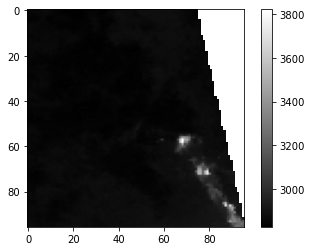

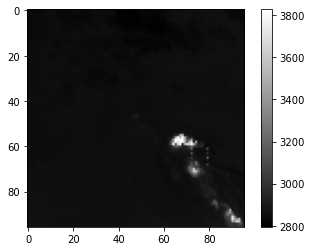

In [6]:
testing = np.load('AST_08_data/Puuoo/darkspot_filled', allow_pickle = True)

for i in range(15, 20):
    plt.imshow(testing[i], cmap = 'gist_gray')
    plt.colorbar()
    plt.pause(0.001)

# Normalizing temperatures with respect to the background average (removes seasonality)

In [7]:
for vol in os.listdir('data/'):
    print(vol)
    # Reconstructing the filepath for the darkspot-filled data and importing it
    neighbor_filled = np.load('AST_08_data/' + vol + '/darkspot_filled', allow_pickle = True)
    neighbor_filled = neighbor_filled / 10
    # Identifying the four corners of the spatial subset to use for background substraction
    max_index = neighbor_filled.shape[1]
    corner_1 = neighbor_filled[:, :10, :10]
    corner_2 = neighbor_filled[:, (max_index-10):max_index, :10]
    corner_3 = neighbor_filled[:, :10, (max_index-10):max_index]
    corner_4 = neighbor_filled[:, (max_index-10):max_index, (max_index-10):max_index]
    # New empty array to store the data values relative to the background
    scene_anamolies = np.zeros_like(neighbor_filled)
    # Storing the reference background values
    background_vals = []
    # For all scenes...
    for i in range(len(neighbor_filled)):
        # Define an empty list, variable length depending on presence of corners with missing values
        valid_corners_means = []
        # For each corner...
        for corner in [corner_1[i], corner_2[i], corner_3[i], corner_4[i]]:
            # Determine the % of missing values in the corner
            percent_missing = np.sum(corner == 2000) / len(corner.flatten())
            # If its less than 10%, consider its mean as valid
            if percent_missing < 0.10:
                valid_corners_means.append(np.mean(corner))
        # Use the median of those possible background values
        if len(valid_corners_means) > 0: 
            background_val = np.mean(valid_corners_means)
            background_vals.append(background_val)
        # Erebus scenes complicate this, sometimes all the corners have invalid values
        # If all the corners are invalid, re-adjust the 'background' patches around the perimeter
        else:
            corner_1 = neighbor_filled[:, 40:50, :10]
            corner_2 = neighbor_filled[:, (max_index-10):max_index, 40:50]
            corner_3 = neighbor_filled[:, :10, (max_index-50):(max_index-40)]
            corner_4 = neighbor_filled[:, (max_index-50):(max_index-40), (max_index-10):max_index]
            for corner in [corner_1[i], corner_2[i], corner_3[i], corner_4[i]]:
                percent_missing = np.sum(corner == 2000) / len(corner.flatten())
                if percent_missing < 0.10:
                    valid_corners_means.append(np.mean(corner))
            if len(valid_corners_means) == 0:
                print(i, 'Too many invalid values to determine background')
            else:
                background_val = np.mean(valid_corners_means)
                background_vals.append(background_val)
        # Perform the background subtraction
        scene_anamolies[i] = neighbor_filled[i] - background_val
    scene_anamolies.dump('AST_08_data/' + vol + '/background_subtracted')

Erebus
ErtaAle
Etna
Kilauea
Masaya
Nyamuragira
Nyiragongo
Pacaya
Puuoo


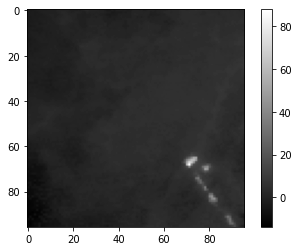

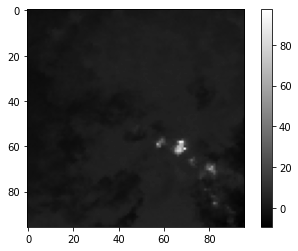

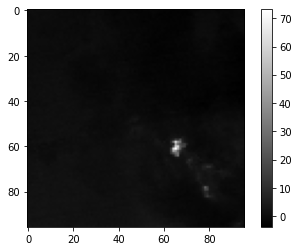

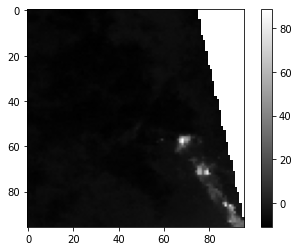

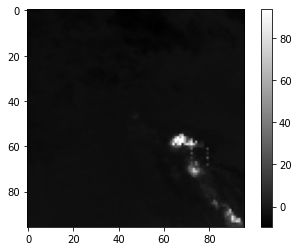

In [8]:
testing = np.load('AST_08_data/Puuoo/background_subtracted', allow_pickle = True)

for i in range(15, 20):
    plt.imshow(testing[i], cmap = 'gist_gray')
    plt.colorbar()
    plt.pause(0.001)

In [9]:
raise(ImportError)

ImportError: 

# Prototyping code that will be in the training script

It will not be done here (permanently at least) because the processing depends in-part on the model used

The cell ordering is different because this part simply requires the first two cells of the whole notebook after the others have already been ran (somewhat time consuming)

In [3]:
num_input_scenes = 6
train_percent = 0.70
out_samp_perc = 0.15
model_selection = 'Identity'

count = 0
vol_cutoff_indices = []
vol_cutoff_indices_valid = []
vol_cutoff_indices_test = []
vol_name_ls = []
for vol in os.listdir('data'):
	### Basic data import ###
	numpy_data_location = "AST_08_data/" + vol + "/background_subtracted"
	table_data_location = "data/" + vol + "/good_df.csv"
	volcano_scenes = np.load(numpy_data_location, allow_pickle = True)
	tabular_metadata = pd.read_csv(table_data_location)
	### Separate model inputs and outputs
	# Determine number in each partition
	train_n = int(np.floor((len(volcano_scenes) - num_input_scenes)*train_percent))
	out_n = int(np.floor((len(volcano_scenes) - num_input_scenes)*out_samp_perc))
	# For every data partition
	# Array for the prior scenes
	#   "train_n - 1" is to remove the first scene that wont have an associated Time-Aware LSTM time interval
	x_scenes_train = ma.zeros([train_n - 1, num_input_scenes, volcano_scenes.shape[1], volcano_scenes.shape[2]])
	x_scenes_valid = ma.zeros([out_n, num_input_scenes, volcano_scenes.shape[1], volcano_scenes.shape[2]])
	x_scenes_test = ma.zeros([out_n, num_input_scenes, volcano_scenes.shape[1], volcano_scenes.shape[2]])
	# Array for the time differences between scenes
	time_differences_train = np.ones(x_scenes_train.shape)
	time_differences_valid = np.ones(x_scenes_valid.shape)
	time_differences_test = np.ones(x_scenes_test.shape)
	# Array for the target scenes
	y_scenes_train = ma.zeros([train_n - 1, 1, volcano_scenes.shape[1], volcano_scenes.shape[2]])
	y_scenes_valid = ma.zeros([out_n, 1, volcano_scenes.shape[1], volcano_scenes.shape[2]])
	y_scenes_test = ma.zeros([out_n, 1, volcano_scenes.shape[1], volcano_scenes.shape[2]])
	# Formatting the string dates as datetime objects
	formatted_dates = [datetime.strptime(date, '%Y-%m-%d') for date in tabular_metadata['dates']]
	# For all observations - acknowledging that the first (n-1) wont have n prior observations
	#     Also, the first data point wont have a Time-Aware LSTM time value, so it is omitted
	for i in range(num_input_scenes + 1, x_scenes_train.shape[0] + x_scenes_valid.shape[0] + x_scenes_test.shape[0] + num_input_scenes+1):
		if i < (train_n + num_input_scenes):
			# Store the image data
			x_scenes_train[i - num_input_scenes - 1, :, :, :] = volcano_scenes[(i - num_input_scenes):i, :, :]
			y_scenes_train[i - num_input_scenes - 1, 0, :, :] = volcano_scenes[i, :, :]
			# Compute the time differences and store
			# Time LSTM uses forward-time interval
			if model_selection in ['TimeLSTM', 'ConvTimeLSTM']:
				dates_i_plus_1 = formatted_dates[(i - num_input_scenes + 1):(i + 1)]
				dates_i = formatted_dates[(i - num_input_scenes):i]
				for j in range(len(dates_i_plus_1)):
					time_differences_train[i - num_input_scenes - 1, j] = (dates_i_plus_1[j] - dates_i[j]).days
			# While Time-Aware LSTM uses backwards-time interval
			else:
				dates_i = formatted_dates[(i - num_input_scenes):i]
				dates_i_minus_1 = formatted_dates[(i - num_input_scenes - 1):(i - 1)]
				for j in range(len(dates_i)):
					time_differences_train[i - num_input_scenes - 1, j] = (dates_i[j] - dates_i_minus_1[j]).days
		elif i < (train_n + out_n + num_input_scenes):
			# Store the image data
			x_scenes_valid[i - train_n - num_input_scenes, :, :, :] = volcano_scenes[(i - num_input_scenes):i, :, :]
			y_scenes_valid[i - train_n - num_input_scenes, 0, :, :] = volcano_scenes[i, :, :]
			# Compute the time differences and store
			# Time LSTM uses forward-time interval
			if model_selection in ['TimeLSTM', 'ConvTimeLSTM']:
				dates_i_plus_1 = formatted_dates[(i - num_input_scenes + 1):(i + 1)]
				dates_i = formatted_dates[(i - num_input_scenes):i]
				for j in range(len(dates_i_plus_1)):
					time_differences_valid[i - num_input_scenes - train_n - 1, j] = (dates_i_plus_1[j] - dates_i[j]).days
			# While Time-Aware LSTM uses backwards-time interval
			else:
				dates_i = formatted_dates[(i - num_input_scenes):i]
				dates_i_minus_1 = formatted_dates[(i - num_input_scenes - 1):(i - 1)]
				for j in range(len(dates_i)):
					time_differences_valid[i - num_input_scenes - train_n - 1, j] = (dates_i[j] - dates_i_minus_1[j]).days
		else:
			# Store the image data
			x_scenes_test[i - train_n - out_n - num_input_scenes, :, :, :] = volcano_scenes[(i - num_input_scenes):i, :, :]
			y_scenes_test[i - train_n - out_n - num_input_scenes, 0, :, :] = volcano_scenes[i, :, :]
			# Compute the time differences and store
			# Time LSTM uses forward-time interval
			if model_selection in ['TimeLSTM', 'ConvTimeLSTM']:
				dates_i_plus_1 = formatted_dates[(i - num_input_scenes + 1):(i + 1)]
				dates_i = formatted_dates[(i - num_input_scenes):i]
				for j in range(len(dates_i_plus_1)):
					time_differences_test[i - num_input_scenes - train_n - out_n - 1, j] = (dates_i_plus_1[j] - dates_i[j]).days
			# While Time-Aware LSTM uses backwards-time interval
			else:
				dates_i = formatted_dates[(i - num_input_scenes):i]
				dates_i_minus_1 = formatted_dates[(i - num_input_scenes - 1):(i - 1)]
				for j in range(len(dates_i)):
					time_differences_test[i - num_input_scenes - train_n - out_n - 1, j] = (dates_i[j] - dates_i_minus_1[j]).days
	if count == 0:
		x_train = x_scenes_train
		t_train = time_differences_train
		y_train = y_scenes_train
		x_valid = x_scenes_valid
		t_valid = time_differences_valid
		y_valid = y_scenes_valid
		x_test = x_scenes_test
		t_test = time_differences_test
		y_test = y_scenes_test
	else:
		x_train = ma.append(x_train, x_scenes_train, axis = 0)
		t_train = np.append(t_train, time_differences_train, axis = 0)
		y_train = ma.append(y_train, y_scenes_train, axis = 0)
		x_valid = ma.append(x_valid, x_scenes_valid, axis = 0)
		t_valid = np.append(t_valid, time_differences_valid, axis = 0)
		y_valid = ma.append(y_valid, y_scenes_valid, axis = 0)
		x_test = ma.append(x_test, x_scenes_test, axis = 0)
		t_test = np.append(t_test, time_differences_test, axis = 0)
		y_test = ma.append(y_test, y_scenes_test, axis = 0)
	count += 1
	vol_cutoff_indices.append(y_train.shape[0])
	vol_cutoff_indices_valid.append(y_valid.shape[0])
	vol_cutoff_indices_test.append(y_test.shape[0])
	vol_name_ls.append(vol)
	print('\timported ' + str(x_scenes_train.shape[0]) + ' training scenes from ' + vol)
	print('\t\timported ' + str(x_scenes_valid.shape[0]) + ' validation scenes from ' + vol)
	print('\t\timported ' + str(x_scenes_test.shape[0]) + ' test scenes from ' + vol)

	imported 334 training scenes from Erebus
		imported 71 validation scenes from Erebus
		imported 71 test scenes from Erebus
	imported 180 training scenes from ErtaAle
		imported 38 validation scenes from ErtaAle
		imported 38 test scenes from ErtaAle
	imported 129 training scenes from Etna
		imported 28 validation scenes from Etna
		imported 28 test scenes from Etna
	imported 153 training scenes from Kilauea
		imported 33 validation scenes from Kilauea
		imported 33 test scenes from Kilauea
	imported 42 training scenes from Masaya
		imported 9 validation scenes from Masaya
		imported 9 test scenes from Masaya
	imported 51 training scenes from Nyamuragira
		imported 11 validation scenes from Nyamuragira
		imported 11 test scenes from Nyamuragira
	imported 72 training scenes from Nyiragongo
		imported 15 validation scenes from Nyiragongo
		imported 15 test scenes from Nyiragongo
	imported 48 training scenes from Pacaya
		imported 10 validation scenes from Pacaya
		imported 10 test scenes

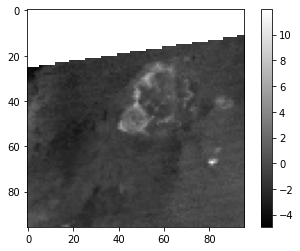

In [4]:
plt.imshow(x_train[334+180+129, 0], cmap = 'gist_gray')
plt.colorbar();

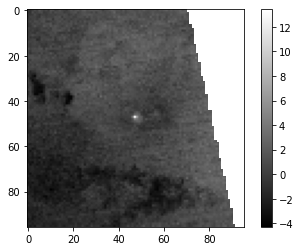

In [5]:
plt.imshow(x_train[334+180+129+153+42-15, 0], cmap = 'gist_gray')
plt.colorbar();

In [6]:
# Gap fill missing values with previous ones or nearest neighbor
for i in range(len(x_train)):
	for j in range(x_train.shape[1]):
		# Identifying missing values
		ma = np.ma.masked_invalid(x_train[i, j, :, :])
		# If the mask found NA values
		if not np.all(x_train[i, j, :, :].mask == False):
			# Using previous value to fill
			if j == 0:
				# Unless there's no previous, then nearest neighbor interpolate
				if i == 0 or i in vol_cutoff_indices:
					print('\t\tNo prior scene; nearest neighbor interpolation')
					scene = x_train[i, j, :, :]
					# Explicitly retrieving good and bad locations from the mask
					# note that these differ from (x, y) which earlier defined bad pixel locations
					X, Y = np.mgrid[0:scene.shape[0], 0:scene.shape[1]]
					xygood = np.array((X[~scene.mask], Y[~scene.mask])).T
					xybad = np.array((X[scene.mask], Y[scene.mask])).T
					# Performing the nearest neighbor gap-filling
					x_train[i, j, :, :][ma.mask == True] = scene[~scene.mask][KDTree(xygood).query(xybad)[1]]
				else:
					x_train[i, j, :, :][ma.mask == True] = x_train[i-1, j, :, :][ma.mask == True]
					t_train[i, j, :, :][ma.mask == True] = t_train[i, j, :, :][ma.mask == True] + t_train[i-1, j, :, :][ma.mask == True]
			else:
				x_train[i, j, :, :][ma.mask == True] = x_train[i, j-1, :, :][ma.mask == True]
				t_train[i, j, :, :][ma.mask == True] = t_train[i, j, :, :][ma.mask == True] + t_train[i, j-1, :, :][ma.mask == True]
for i in range(len(x_valid)):
	for j in range(x_valid.shape[1]):
		# Identifying missing values
		ma = np.ma.masked_invalid(x_valid[i, j, :, :])
		# If the mask found NA values
		if not np.all(ma.mask == False):
			# Using previous value to fill
			if j == 0:
				# Unless there's no previous, then nearest neighbor interpolate
				if i == 0 or i in vol_cutoff_indices_valid:
					scene = x_valid[i, j, :, :]
					# Explicitly retrieving good and bad locations from the mask
					# note that these differ from (x, y) which earlier defined bad pixel locations
					X, Y = np.mgrid[0:scene.shape[0], 0:scene.shape[1]]
					xygood = np.array((X[~scene.mask], Y[~scene.mask])).T
					xybad = np.array((X[scene.mask], Y[scene.mask])).T
					# Performing the nearest neighbor gap-filling
					x_valid[i, j, :, :][ma.mask == True] = scene[~scene.mask][KDTree(xygood).query(xybad)[1]]
				else:
					x_valid[i, j, :, :][ma.mask == True] = x_valid[i-1, j, :, :][ma.mask == True]
					t_valid[i, j, :, :][ma.mask == True] = t_valid[i, j, :, :][ma.mask == True] + t_valid[i-1, j, :, :][ma.mask == True]
			else:
				x_valid[i, j, :, :][ma.mask == True] = x_valid[i, j-1, :, :][ma.mask == True]
				t_valid[i, j, :, :][ma.mask == True] = t_valid[i, j, :, :][ma.mask == True] + t_valid[i, j-1, :, :][ma.mask == True]
for i in range(len(x_test)):
	for j in range(x_test.shape[1]):
		# Identifying missing values
		ma = np.ma.masked_invalid(x_test[i, j, :, :])
		# If the mask found NA values
		if not np.all(ma.mask == False):
			# Using previous value to fill
			if j == 0:
				# Unless there's no previous, then nearest neighbor interpolate
				if i == 0 or i in vol_cutoff_indices_test:
					scene = x_test[i, j, :, :]
					# Explicitly retrieving good and bad locations from the mask
					# note that these differ from (x, y) which earlier defined bad pixel locations
					X, Y = np.mgrid[0:scene.shape[0], 0:scene.shape[1]]
					xygood = np.array((X[~scene.mask], Y[~scene.mask])).T
					xybad = np.array((X[scene.mask], Y[scene.mask])).T
					# Performing the nearest neighbor gap-filling
					x_test[i, j, :, :][ma.mask == True] = scene[~scene.mask][KDTree(xygood).query(xybad)[1]]
				else:
					x_test[i, j, :, :][ma.mask == True] = x_test[i-1, j, :, :][ma.mask == True]
					t_test[i, j, :, :][ma.mask == True] = t_test[i, j, :, :][ma.mask == True] + t_test[i-1, j, :, :][ma.mask == True]
			else:
				x_test[i, j, :, :][ma.mask == True] = x_test[i, j-1, :, :][ma.mask == True]
				t_test[i, j, :, :][ma.mask == True] = t_test[i, j, :, :][ma.mask == True] + t_test[i, j-1, :, :][ma.mask == True]
for i in range(len(y_train)):
	ma = np.ma.masked_invalid(y_train[i, :, :])
	# If the mask found NA values
	if not np.all(ma.mask == False):
		if i == 0 or i in vol_cutoff_indices: 
			y_train[i, :, :][ma.mask == True] = x_train[i, [-1], :, :][ma.mask == True]
		else:
			y_train[i, :, :][ma.mask == True] = y_train[i-1, :, :, :][ma.mask == True]
for i in range(len(y_valid)):
	ma = np.ma.masked_invalid(y_valid[i, :, :, :])
	# If the mask found NA values
	if not np.all(ma.mask == False):
		if i == 0 or i in vol_cutoff_indices_valid:
			y_valid[i, :, :, :][ma.mask == True] = x_valid[i, [-1], :, :][ma.mask == True]
		else:
			y_valid[i, :, :, :][ma.mask == True] = y_valid[i-1, :, :, :][ma.mask == True]
for i in range(len(y_test)):
	ma = np.ma.masked_invalid(y_test[i, :, :, :])
	# If the mask found NA values
	if not np.all(ma.mask == False):
		if i == 0 or i in vol_cutoff_indices_test:
			y_test[i, :, :, :][ma.mask == True] = x_test[i, [-1], :, :][ma.mask == True]
		else:
			y_test[i, :, :, :][ma.mask == True] = y_test[i-1, :, :, :][ma.mask == True]

		No prior scene; nearest neighbor interpolation
		No prior scene; nearest neighbor interpolation
		No prior scene; nearest neighbor interpolation
		No prior scene; nearest neighbor interpolation


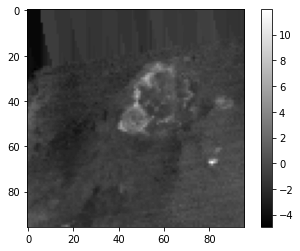

In [7]:
plt.imshow(x_train[334+180+129, 0], cmap = 'gist_gray')
plt.colorbar();

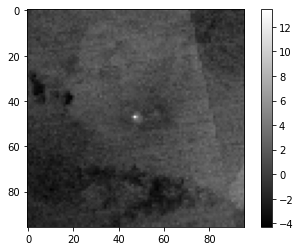

In [8]:
plt.imshow(x_train[334+180+129+153+42-15, 0], cmap = 'gist_gray')
plt.colorbar();